# Permanent Magnet Synchrone Motor


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score,mean_squared_error


from sklearn import svm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
#seaborn
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



from sklearn import neighbors
from math import sqrt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

data/pmsm_temperature_data.csv


## read data


In [2]:

#df = pd.read_csv('data/pmsm_temperature_data.csv', 
#                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11])

df = pd.read_csv('data/pmsm_temperature_data.csv')
#df = pd.read_csv('../input/pmsm_temperature_data.csv', 
 #                usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head(10)

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   
5 -0.762936 -1.116955  0.334901 -1.303017    -1.222429 -0.248197  1.031031   
6 -0.749228 -1.116170  0.335014 -1.302082    -1.222430 -0.247914  1.030493   
7 -0.738450 -1.113986  0.336256 -1.305155    -1.222432 -0.248321  1.030107   
8 -0.730910 -1.111828  0.334905 -1.303790    -1.222432 -0.247785  1.029851   
9 -0.727130 -1.109486  0.335988 -1.305633    -1.222431 -0.248294  1.029636   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4  
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4  
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4  
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4  
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4  
5 -0.246341 -2.522203    -1.831931     -2.062549       -2.017884           4  
6 -0.246162 -2.522538    -1.833012     -2.062115       -2.017243           4  
7 -0.246035 -2.522844    -1.832182     -2.061953       -2.017213           4  
8 -0.245981 -2.522808    -1.831576     -2.062443       -2.017739           4  
9 -0.245888 -2.522677    -1.831438     -2.062317       -2.018180           4

## data description


In [3]:
df.info()


&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


In [4]:
df.describe().T


count       mean        std       min        25%  \
ambient         998070.0  -0.003905   0.993127 -8.573954  -0.599385   
coolant         998070.0   0.004723   1.002423 -1.429349  -1.037925   
u_d             998070.0   0.004780   0.997878 -1.655373  -0.826359   
u_q             998070.0  -0.005690   1.002330 -1.861463  -0.927390   
motor_speed     998070.0  -0.006336   1.001229 -1.371529  -0.951892   
torque          998070.0  -0.003333   0.997907 -3.345953  -0.266917   
i_d             998070.0   0.006043   0.998994 -3.245874  -0.756296   
i_q             998070.0  -0.003194   0.997912 -3.341639  -0.257269   
pm              998070.0  -0.004396   0.995686 -2.631991  -0.672308   
stator_yoke     998070.0   0.000609   1.001049 -1.834688  -0.747265   
stator_tooth    998070.0  -0.002208   0.999597 -2.066143  -0.761951   
stator_winding  998070.0  -0.003935   0.998343 -2.019973  -0.725622   
profile_id      998070.0  50.732001  22.073125  4.000000  32.000000   

                      50%        75%        max  
ambient          0.266157   0.686675   2.967117  
coolant         -0.177187   0.650709   2.649032  
u_d              0.267542   0.358491   2.274734  
u_q             -0.099818   0.852625   1.793498  
motor_speed     -0.140246   0.853584   2.024164  
torque          -0.187246   0.547171   3.016971  
i_d              0.213935   1.013975   1.060937  
i_q             -0.190076   0.499260   2.914185  
pm               0.094367   0.680691   2.917456  
stator_yoke     -0.057226   0.697344   2.449158  
stator_tooth     0.005085   0.772239   2.326668  
stator_winding   0.006536   0.725660   2.653781  
profile_id      56.000000  68.000000  81.000000

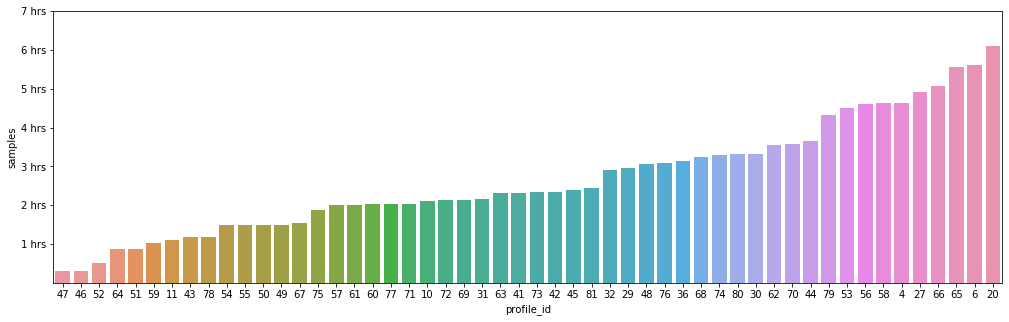

In [5]:
# show 
fig = plt.figure(figsize=(17, 5))
grpd = df.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate

In [6]:
df.isnull().values.any()


False

In [7]:
nans=pd.isnull(df).sum()
nans[nans>0]

Series([], dtype: int64)

In [8]:
df.dtypes.value_counts()

float64    12
int64       1
dtype: int64

In [9]:
df.corr()

ambient   coolant       u_d       u_q  motor_speed    torque  \
ambient         1.000000  0.434435  0.194754  0.087430     0.078283 -0.262264   
coolant         0.434435  1.000000  0.178708  0.027851    -0.033332 -0.189617   
u_d             0.194754  0.178708  1.000000 -0.027472    -0.233828 -0.821325   
u_q             0.087430  0.027851 -0.027472  1.000000     0.716897 -0.037262   
motor_speed     0.078283 -0.033332 -0.233828  0.716897     1.000000  0.024517   
torque         -0.262264 -0.189617 -0.821325 -0.037262     0.024517  1.000000   
i_d             0.005605  0.108489  0.358517 -0.181855    -0.722914 -0.239059   
i_q            -0.260562 -0.186060 -0.796586 -0.026348     0.006323  0.996560   
pm              0.501496  0.430548 -0.082564  0.101236     0.332419 -0.072905   
stator_yoke     0.451616  0.874037  0.041428  0.106186     0.182564 -0.092207   
stator_tooth    0.396742  0.689003 -0.066256  0.149017     0.333909 -0.011055   
stator_winding  0.301883  0.509298 -0.150714  0.125445     0.393154  0.080981   
profile_id      0.384565  0.499669  0.300771 -0.122260    -0.166225 -0.257446   

                     i_d       i_q        pm  stator_yoke  stator_tooth  \
ambient         0.005605 -0.260562  0.501496     0.451616      0.396742   
coolant         0.108489 -0.186060  0.430548     0.874037      0.689003   
u_d             0.358517 -0.796586 -0.082564     0.041428     -0.066256   
u_q            -0.181855 -0.026348  0.101236     0.106186      0.149017   
motor_speed    -0.722914  0.006323  0.332419     0.182564      0.333909   
torque         -0.239059  0.996560 -0.072905    -0.092207     -0.011055   
i_d             1.000000 -0.204230 -0.299227    -0.179903     -0.387712   
i_q            -0.204230  1.000000 -0.086486    -0.098753     -0.025191   
pm             -0.299227 -0.086486  1.000000     0.695014      0.768352   
stator_yoke    -0.179903 -0.098753  0.695014     1.000000      0.949898   
stator_tooth   -0.387712 -0.025191  0.768352     0.949898      1.000000   
stator_winding -0.539924  0.060949  0.729561     0.845144      0.965633   
profile_id      0.142368 -0.256127  0.156735     0.398021      0.280994   

                stator_winding  profile_id  
ambient               0.301883    0.384565  
coolant               0.509298    0.499669  
u_d                  -0.150714    0.300771  
u_q                   0.125445   -0.122260  
motor_speed           0.393154   -0.166225  
torque                0.080981   -0.257446  
i_d                  -0.539924    0.142368  
i_q                   0.060949   -0.256127  
pm                    0.729561    0.156735  
stator_yoke           0.845144    0.398021  
stator_tooth          0.965633    0.280994  
stator_winding        1.000000    0.181908  
profile_id            0.181908    1.000000

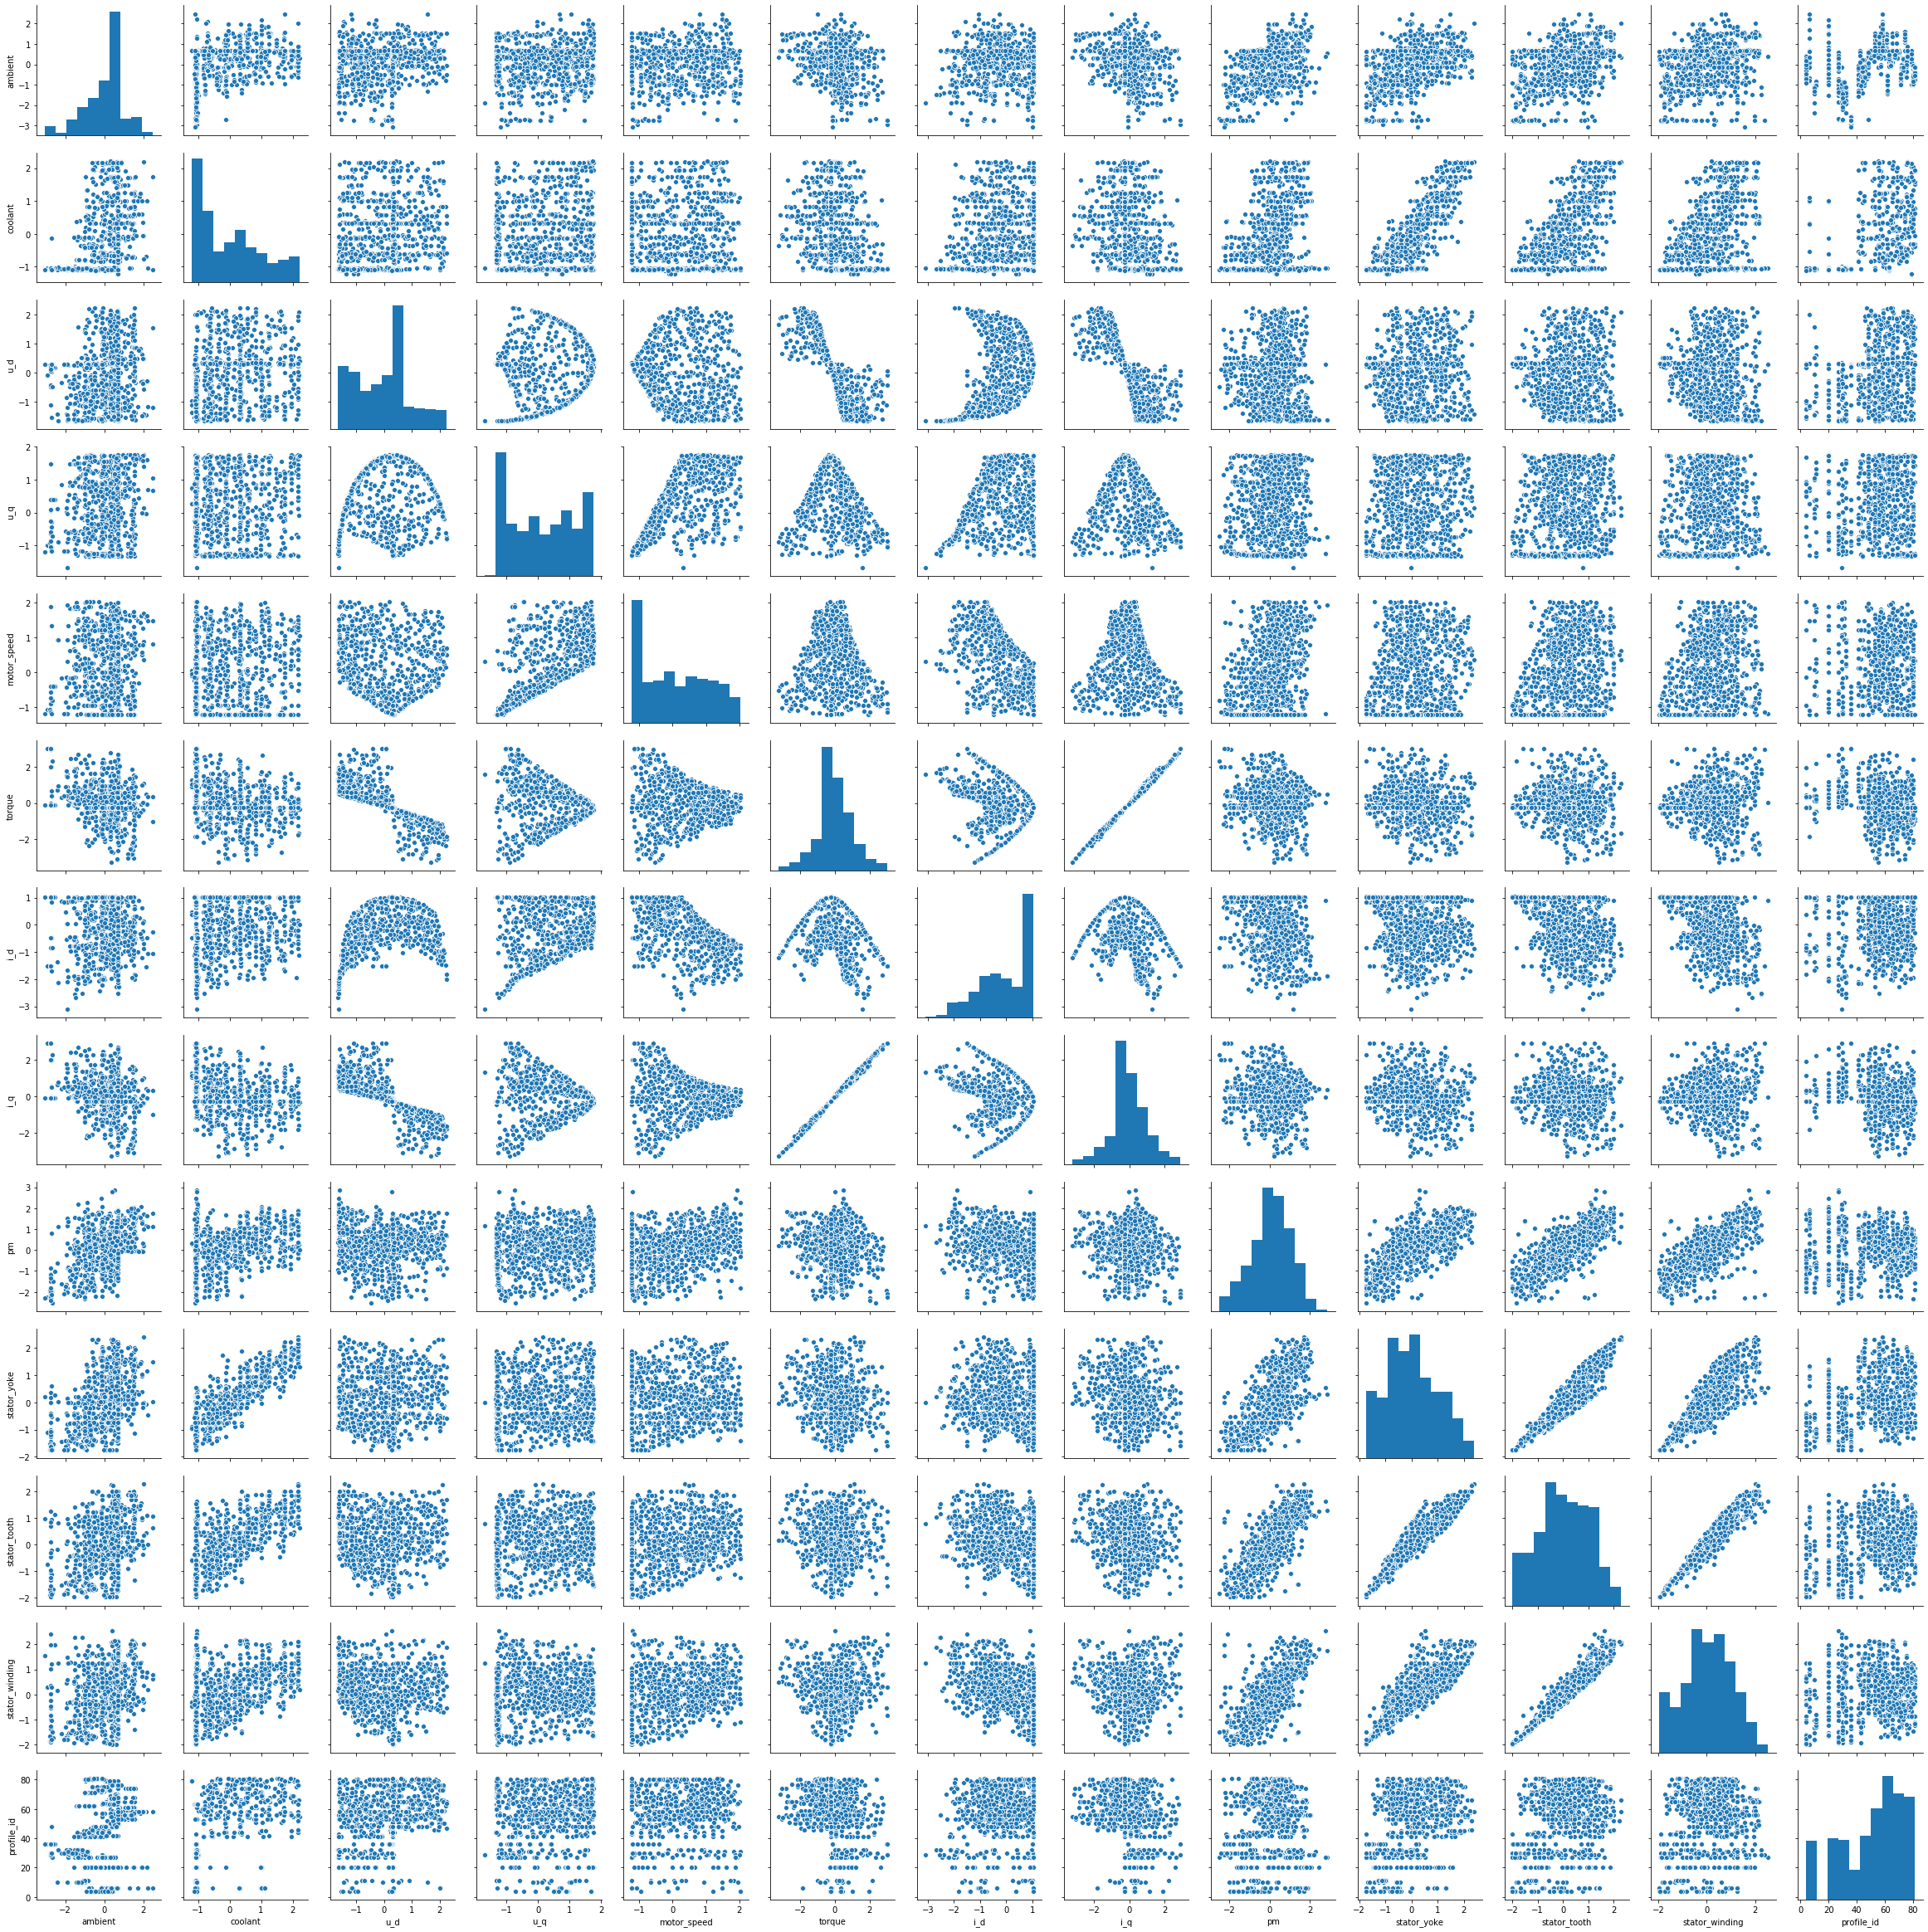

In [10]:
#sns.jointplot(x='i_d', y='motor_speed', data=df,  kind='reg')
#sns.pairplot(df.sample(1000))
sns.pairplot(df.sample(frac=0.0001))

plt.show()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f842ba290d0&gt;

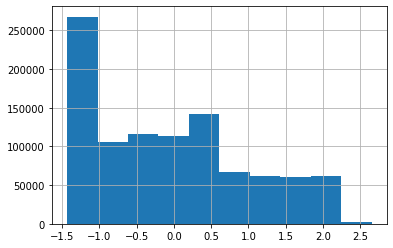

In [11]:
df['coolant'].hist()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f842babd990&gt;

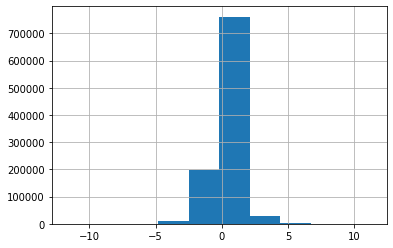

In [12]:
# coolant
df2 = df.copy()

coolant = df2['coolant']
logCoolant = np.sign(coolant)*np.log(abs(coolant))

# new coolant scaled : log transformation from coolant
logCoolant.hist( )


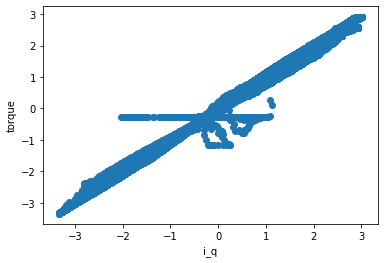

In [13]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(df2['torque'],df2['i_q'])
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("i_q")
plt.ylabel("torque")
plt.show()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f842bafe8d0&gt;

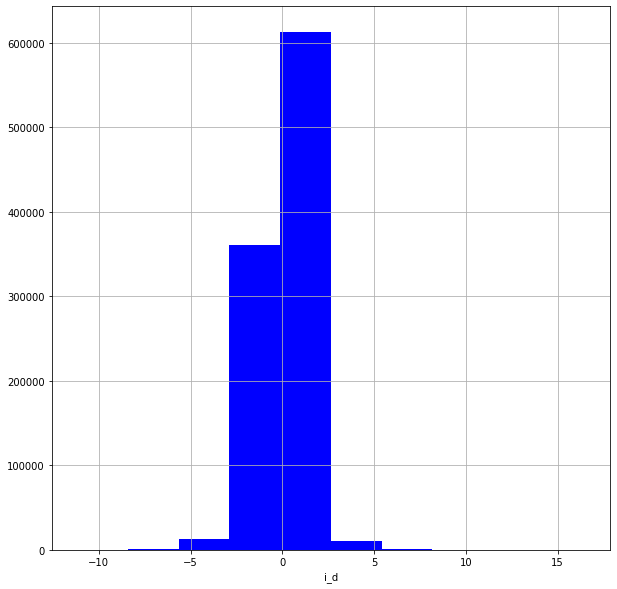

In [14]:

I_d = df2['i_d']
logI_d = np.sign(I_d)*np.log(abs(I_d))

# new coolant scaled : log transformation from coolant
f,ax=plt.subplots(figsize=(10,10))
I_d.hist(ax=ax, color="b")
ax.set_xlabel('i_d')
#ax.set_title('histogramme i_d')
logI_d.hist(ax=ax ,color="b")


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f842dc1af10&gt;

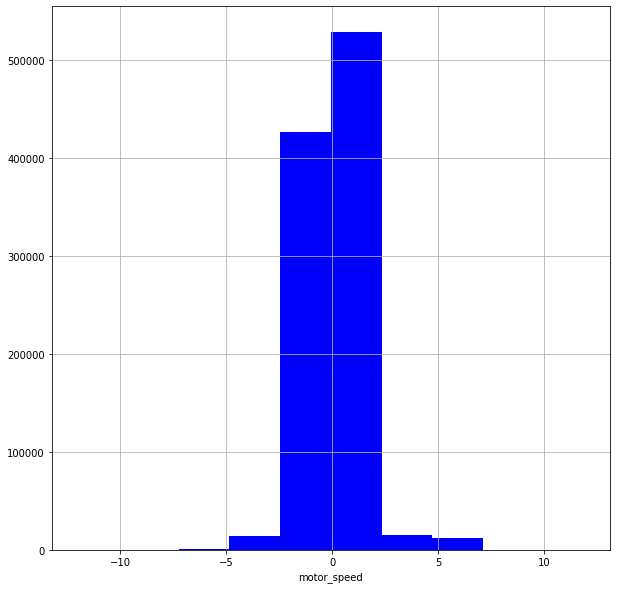

In [15]:

motor_speed = df2['motor_speed']
logmotor_speed = np.sign(motor_speed)*np.log(abs(motor_speed))

# new coolant scaled : log transformation from coolant
f,ax=plt.subplots(figsize=(10,10))
motor_speed.hist(ax=ax, color="b")
ax.set_xlabel('motor_speed')
#ax.set_title('histogramme i_d')
logmotor_speed.hist(color="b")

In [16]:
# scale and normalization
# log normalization 
# coolant is long right tail 
#df['newCoolantlog'] = df.coolant.map(np.log)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
df2afterTransformation = df2.drop(['coolant', 'i_d', 'motor_speed'], axis =1)
df2afterTransformation['logCoolant'] = logCoolant
df2afterTransformation['logI_d'] = logI_d
df2afterTransformation['logMotor_speed'] = logmotor_speed
ss.fit(df2afterTransformation)
from pandas import DataFrame

df2afterTransformationScale = DataFrame(ss.transform(df2afterTransformation, copy=True), columns=df2afterTransformation.columns)




In [17]:
df2afterTransformationScale.describe().T


count          mean       std        min       25%  \
ambient         998070.0 -8.710865e-14  1.000001  -8.629364 -0.599601   
u_d             998070.0 -5.432324e-15  1.000001  -1.663685 -0.832907   
u_q             998070.0  3.209995e-16  1.000001  -1.851460 -0.919558   
torque          998070.0 -5.696427e-13  1.000001  -3.349634 -0.264138   
i_q             998070.0  9.691522e-16  1.000001  -3.345431 -0.254607   
pm              998070.0 -1.484235e-15  1.000001  -2.638981 -0.670806   
stator_yoke     998070.0 -1.530093e-14  1.000001  -1.833374 -0.747091   
stator_tooth    998070.0  1.157004e-15  1.000001  -2.064767 -0.760049   
stator_winding  998070.0 -6.732676e-15  1.000001  -2.019386 -0.722885   
profile_id      998070.0 -9.930510e-13  1.000001  -2.117146 -0.848634   
logCoolant      998070.0  4.226449e-15  1.000001 -12.062947 -0.208480   
logI_d          998070.0  2.197153e-15  1.000001 -11.584964 -0.370306   
logMotor_speed  998070.0 -5.532915e-15  1.000001 -10.703135 -0.290281   

                     50%       75%        max  
ambient         0.271932  0.695360   2.991585  
u_d             0.263321  0.354463   2.274782  
u_q            -0.093909  0.856320   1.795006  
torque         -0.184299  0.551659   3.026641  
i_q            -0.187273  0.503506   2.923484  
pm              0.099191  0.688056   2.934512  
stator_yoke    -0.057774  0.696005   2.445984  
stator_tooth    0.007296  0.774759   2.329815  
stator_winding  0.010489  0.730807   2.662129  
profile_id      0.238661  0.782309   1.371261  
logCoolant     -0.143405  0.430950  11.430807  
logI_d          0.074960  0.121353  17.215473  
logMotor_speed -0.070246  0.307821  10.357088

&lt;seaborn.axisgrid.PairGrid at 0x7f8430e90a50&gt;

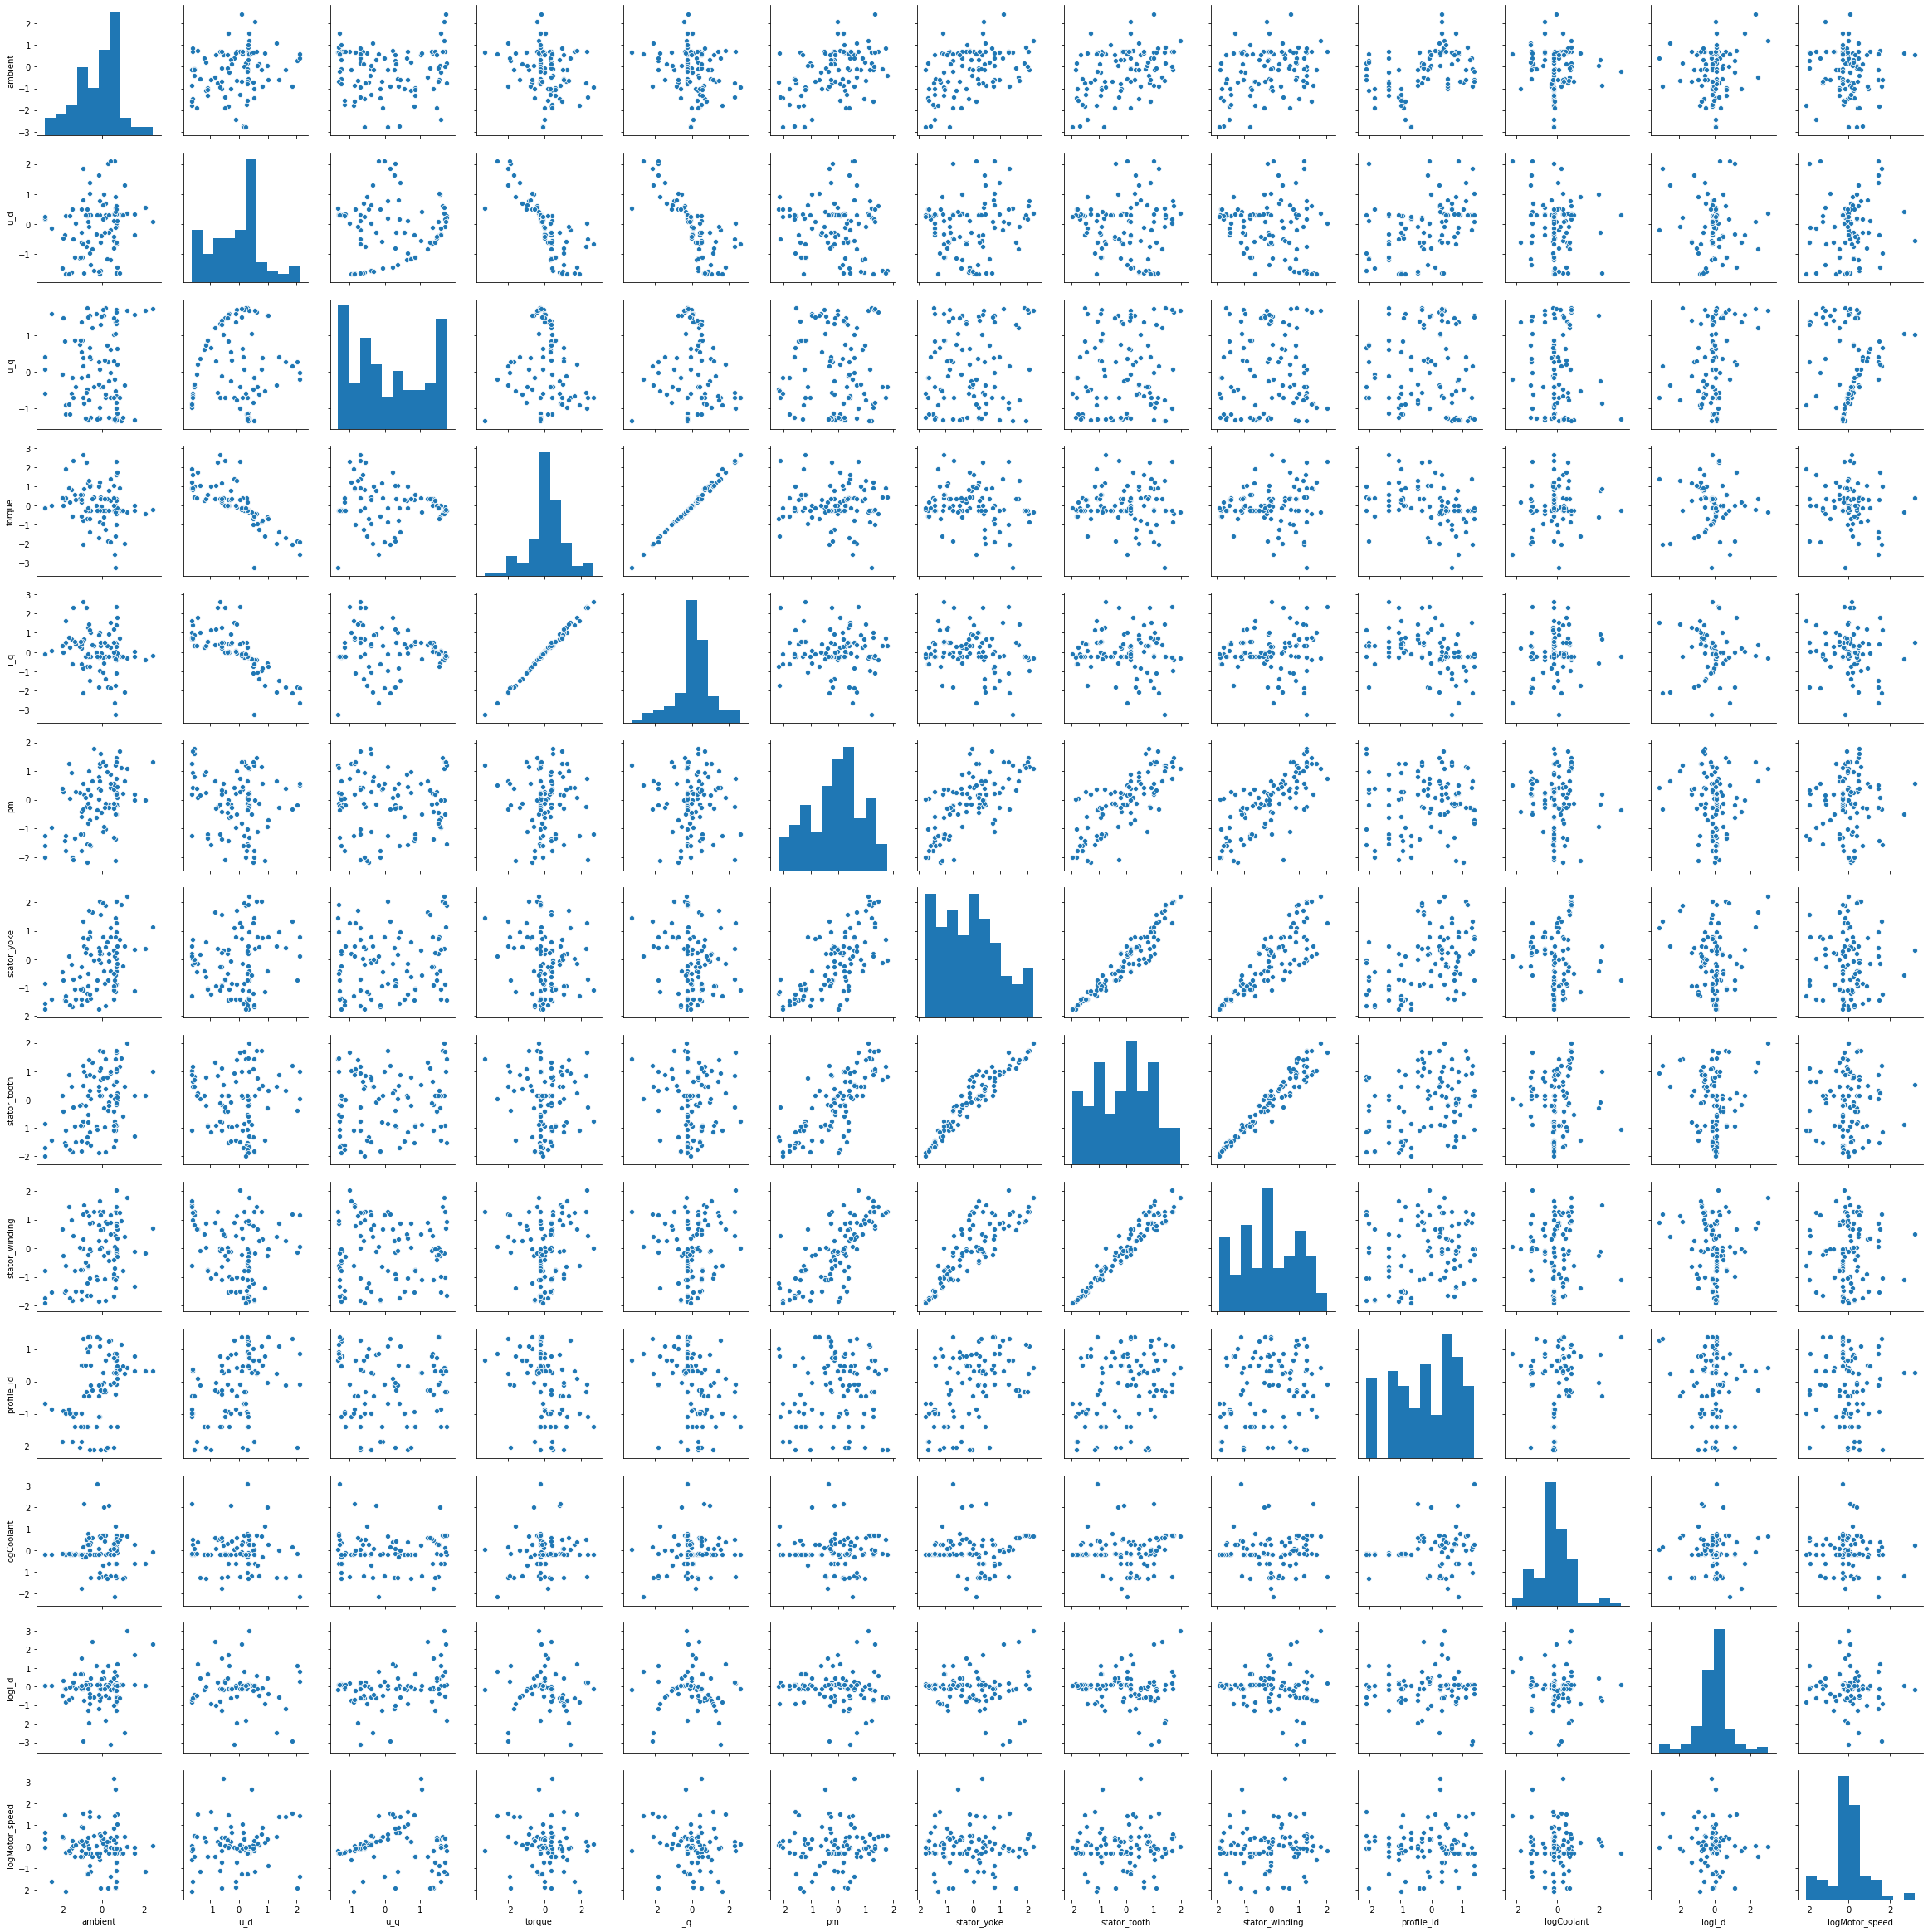

In [18]:
# plot scaled

sns.pairplot(df2afterTransformationScale.sample(frac=0.0001))





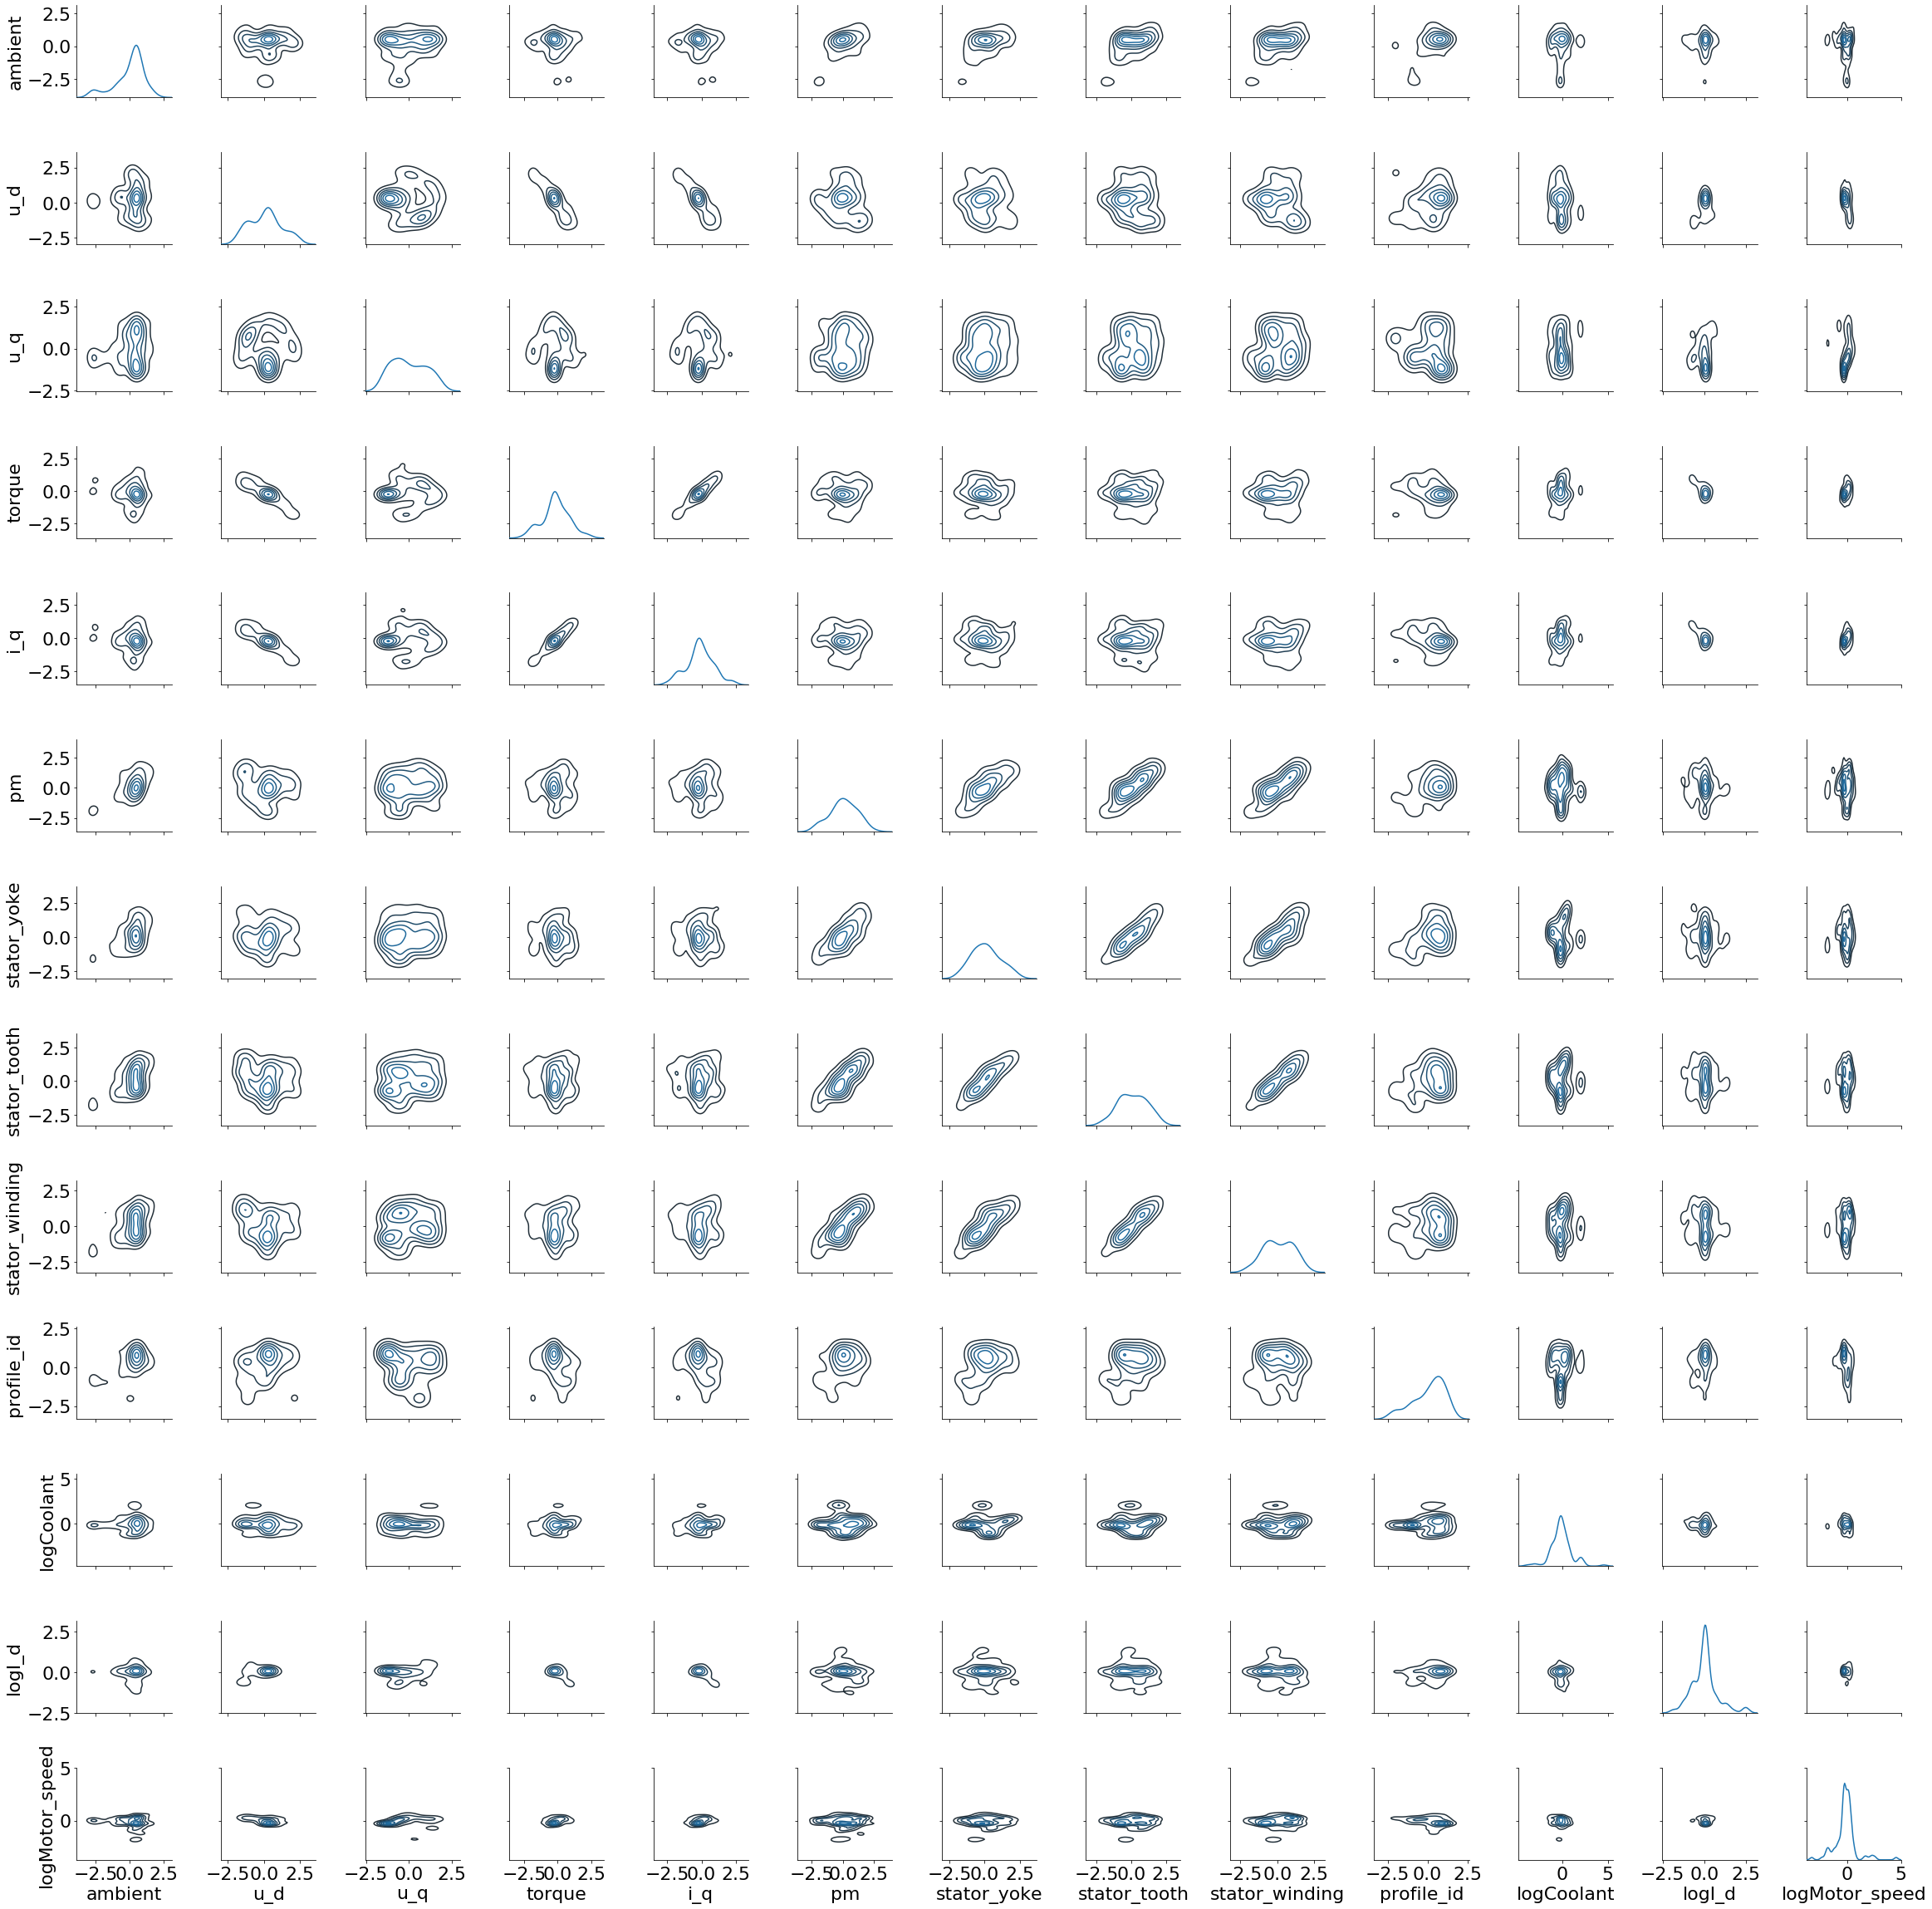

In [19]:
#reduced_df = df.drop(['stator_yoke', 'stator_tooth', 'stator_winding'], axis=1)
matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df2afterTransformationScale.sample(frac=0.0001))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

## correlation map

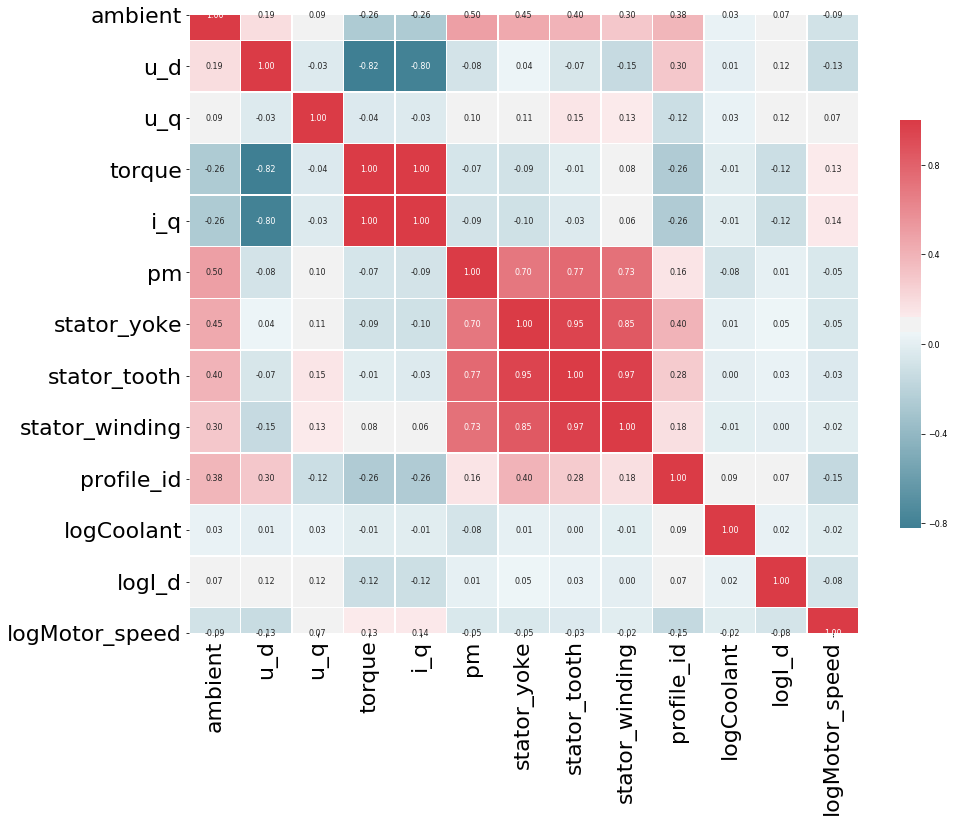

In [20]:
#correlation map
f,ax=plt.subplots(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 8})

corr=df2afterTransformationScale.corr()

sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5},
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax)



plt.show()

In [21]:
# il faut ajouter une feature executionTime per profile
## pas necessaire car l'état de demarrage est aléatoire (le moteur peut ne pas commencer à froid lors d'une session)

In [22]:
# after scaling
X=df2afterTransformationScale.drop(['profile_id',"pm" , "torque", 'stator_tooth','stator_yoke', 'stator_winding'], axis=1)
y=df2afterTransformationScale["pm"]

# whithout scaling
X2=df2afterTransformation.drop(['profile_id',"pm" , "torque", 'stator_tooth','stator_yoke', 'stator_winding'], axis=1)
y2=df2afterTransformation["pm"]




from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.2, random_state=42)



# lasso

In [80]:
## extention du modele avec des ewmas
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']

extra_feats = {
     'i_s': lambda x: np.sqrt(x['i_d']**2 + x['i_q']**2),  # Current vector norm
     'u_s': lambda x: np.sqrt(x['u_d']**2 + x['u_q']**2),  # Voltage vector norm
     'S_el': lambda x: x['i_s']*x['u_s'],                  # Apparent power
     'P_el': lambda x: x['i_d'] * x['u_d'] + x['i_q'] *x['u_q'],  # Effective power
     'i_s_x_w': lambda x: x['i_s']*x['motor_speed'],
     'S_x_w': lambda x: x['S_el']*x['motor_speed'],
}
df = df.assign(**extra_feats)

spans = [6360, 3360, 1320, 9480]  # these values correspond to cutoff-frequencies in terms of low pass filters, or half-life in terms of EWMAs, respectively
max_span = max(spans)
enriched_profiles = []
for p_id, p_df in df.groupby(['profile_id']):
    target_df = p_df.loc[:, target_features].reset_index(drop=True)
    # pop out features we do not want to calculate the EWMA from
    p_df = p_df.drop(target_features + ['profile_id'], axis=1).reset_index(drop=True)
    
    # prepad with first values repeated until max span in order to get unbiased EWMA during first observations
    prepadding = pd.DataFrame(np.zeros((max_span, len(p_df.columns))),
                              columns=p_df.columns)
    temperature_cols = [c for c in ['ambient', 'coolant'] if c in df]
    prepadding.loc[:, temperature_cols] = p_df.loc[0, temperature_cols].values

    # prepad
    prepadded_df = pd.concat([prepadding, p_df], axis=0, ignore_index=True)
    ewma = pd.concat([prepadded_df.ewm(span=s).mean().rename(columns=lambda c: f'{c}_ewma_{s}') for s in spans], axis=1).astype(np.float32)
    ewma = ewma.iloc[max_span:, :].reset_index(drop=True)  # remove prepadding
    assert len(p_df) == len(ewma) == len(target_df), f'{len(p_df)}, {len(ewma)}, and {len(target_df)} do not match'
    new_p_df = pd.concat([p_df, ewma, target_df], axis=1)
    new_p_df['profile_id'] = p_id
    enriched_profiles.append(new_p_df.dropna())
enriched_df = pd.concat(enriched_profiles, axis=0, ignore_index=True)  

# normalize
p_ids = enriched_df.pop('profile_id')
scaler = StandardScaler()
enriched_df = pd.DataFrame(scaler.fit_transform(enriched_df), columns=enriched_df.columns)
# please note that we standardize the full data here, yet this is not statistically sound procedure.
# In order to get an unflawed generalization measure of any model evaluated on the data only the training set should be used for fitting the scaler.
# Depending on the CV used this might mean to scale repeatedly with different subsets

In [81]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774

#dfLasso = df.copy()
dfLasso = enriched_df.copy()

X=dfLasso.drop([#'profile_id', 
                "pm" ,"torque", "stator_tooth",'stator_yoke', 'stator_winding' 
                ,'i_d' 
                ,'coolant' 
                ,'motor_speed'
                    ],
               axis=1)
y=dfLasso["pm"]


X['logCoolant'] = logCoolant
X['logI_d'] = logI_d
X['logmotor_speed'] = logmotor_speed


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [82]:
#régression Lasso, paramètres par défaut (alpha = 1.0)
from sklearn.linear_model import Lasso, LassoCV
lasso = Lasso(fit_intercept=False,normalize=False)
print(lasso)
Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
 normalize=False, positive=False, precompute=False, random_state=None,
 selection='cyclic', tol=0.0001, warm_start=False)
#apprentissage
lasso.fit(X_train_transformed,y_train_transformed)
print(lasso.coef_)

Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection=&#39;cyclic&#39;, tol=0.0001, warm_start=False)
[ 0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.
  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.]


In [83]:
# compute alphas for lasso
my_alphas = np.array([0.0001,0.001,0.002,0.003,0.004,0.007,0.009,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6])
#obtention des valeurs des coefs. corresp.
from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
print(coefs_lasso.shape) 

(69, 15)


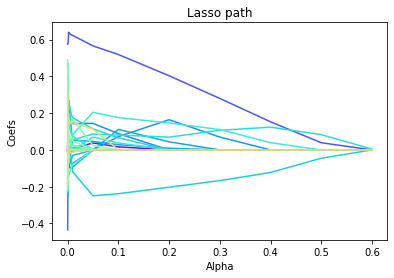

In [84]:
#lass path
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,100))
#graphique lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]):
 plt.plot(alpha_for_path,coefs_lasso[i,:],c=colors[i])

plt.xlabel('Alpha')
plt.ylabel('Coefs')
plt.title('Lasso path')
plt.show()

     alpha  Nb non-zero coefs
0   0.6000                  1
1   0.5000                  3
2   0.4000                  4
3   0.3000                  5
4   0.2000                  7
5   0.1000                 11
6   0.0500                 14
7   0.0100                 22
8   0.0090                 24
9   0.0070                 26
10  0.0040                 27
11  0.0030                 28
12  0.0020                 29
13  0.0010                 37
14  0.0001                 61


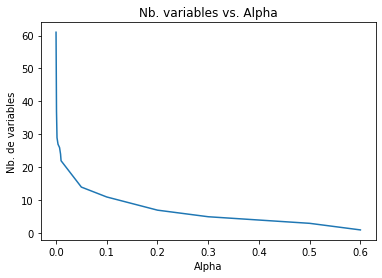

            Variables  Coefficients
0             ambient      0.000127
1                 u_d      0.000000
2                 u_q     -0.003066
3                 i_q     -0.000000
4                 i_s     -0.000638
..                ...           ...
64  i_s_x_w_ewma_9480      0.000000
65    S_x_w_ewma_9480      0.142846
66         logCoolant     -0.013812
67             logI_d     -0.000000
68     logmotor_speed      0.003592

[69 rows x 2 columns]


In [85]:
#nombre de coefs. non-nuls pour chaque alpha
import pandas
nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(pandas.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero}))

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. de variables')
plt.title('Nb. variables vs. Alpha')
plt.show()

#nom des variables
nom_var = X_train.columns
#coefficients pour alpha=0.007 (colonne n°9)
coefsForAlpha = coefs_lasso[:,9]
#affichage des coefficients pour alpha = 0.007
print(pandas.DataFrame({'Variables':nom_var,'Coefficients':coefsForAlpha}))

In [86]:
#outil pour la détection de la solution la plus performante en validation croisée
#random_state = 0 pour fixer l’initialisation du générateur de nombre aléatoire
#cv = 5 pour 5-fold validation croisée
lcv = LassoCV(alphas=my_alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)

#lancement sur l'échantillon d'apprentissage
lcv.fit(X_train_transformed,y_train_transformed) 
print(lcv.alphas_) 
#valeurs des MSE en validation croisée
print(lcv.mse_path_)




[6.e-01 5.e-01 4.e-01 3.e-01 2.e-01 1.e-01 5.e-02 1.e-02 9.e-03 7.e-03
 4.e-03 3.e-03 2.e-03 1.e-03 1.e-04]
[[0.9884575  0.99407461 0.99141092 0.99968704 1.00026677]
 [0.81226867 0.81712553 0.81629007 0.82447423 0.82374436]
 [0.56999695 0.57291163 0.5729324  0.5794717  0.57812987]
 [0.36555083 0.36706892 0.36761461 0.37212451 0.37065754]
 [0.21402853 0.2146165  0.21509417 0.21778738 0.21706536]
 [0.0998458  0.09999989 0.10015762 0.10112911 0.10126303]
 [0.06599611 0.06613443 0.06604399 0.06620351 0.06669221]
 [0.04649142 0.0465862  0.04629942 0.0459707  0.0466908 ]
 [0.04581665 0.04591448 0.04562413 0.04530801 0.04600708]
 [0.04419701 0.04432277 0.04400326 0.04368945 0.04437381]
 [0.04242371 0.04258922 0.04222074 0.04193989 0.04258478]
 [0.04192154 0.04210194 0.04172249 0.04145018 0.04208693]
 [0.04142823 0.04163483 0.04124203 0.04096682 0.0416024 ]
 [0.04041432 0.04062444 0.04022545 0.03998054 0.04058478]
 [0.03652983 0.03679945 0.03633472 0.03614653 0.03672758]]


     alpha       MSE
0   0.6000  0.994779
1   0.5000  0.818781
2   0.4000  0.574689
3   0.3000  0.368603
4   0.2000  0.215718
5   0.1000  0.100479
6   0.0500  0.066214
7   0.0100  0.046408
8   0.0090  0.045734
9   0.0070  0.044117
10  0.0040  0.042352
11  0.0030  0.041857
12  0.0020  0.041375
13  0.0010  0.040366
14  0.0001  0.036508


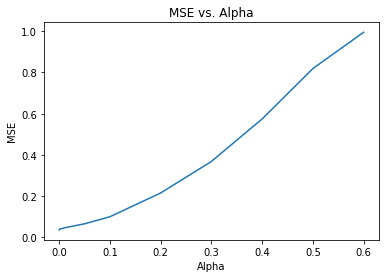

best alpha
0.0001


In [87]:
#moyenne mse en validation croisée pour chaque alpha
avg_mse = np.mean(lcv.mse_path_,axis=1)
#alphas vs. MSE en cross-validation
print(pandas.DataFrame({'alpha':lcv.alphas_,'MSE':avg_mse})) 
#sous-forme graphique
plt.plot(lcv.alphas_,avg_mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alpha')
plt.show()

#best alpha
print('best alpha')
print(lcv.alpha_) 

In [88]:
ypredictedtestLasso = lcv.predict(X_test_transformed)
ypLassoinversed = ss.inverse_transform(ypredictedtestLasso)

#LassoRmseTest=np.sqrt(mean_squared_error(y_test,ypLassoinversed))
#LassoRmseTest
# performance de prediction
print('MSE')
mean_squared_error(y_test,ypLassoinversed)

MSE


0.03667499933366082

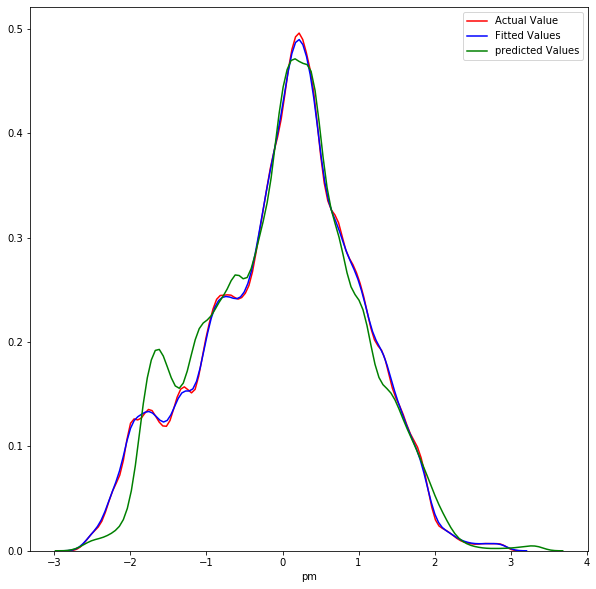

In [89]:
import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(ypLassoinversed, hist=False, color="g", label="predicted Values" , ax=ax1);

In [90]:
import numpy
def plotPredictedVsObserved(y_truth, y_pred):
    #graphique
    import matplotlib.pyplot as plt
    ax = plt.scatter(y_test,ypLassoinversed)
    #plt.scatter(y2_test,y2preditTest)
    #plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
    plt.xlabel("Observed values")
    plt.ylabel("Predicted values")
    plt.show()



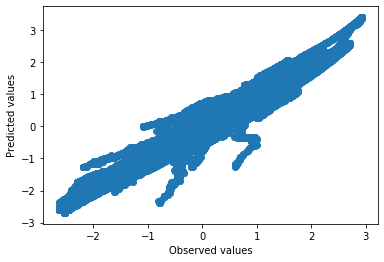

In [91]:
plotPredictedVsObserved(y_test,ypLassoinversed)

OLS

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
#ss = StandardScaler() # -> 0.773837209163774
ss = MinMaxScaler()# -> good 

#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfOLS = df.copy()

X=dfOLS.drop(['profile_id', "pm" ,"torque", "stator_tooth",'stator_yoke', 'stator_winding' 
                ,'i_d' 
                ,'coolant' 
                #,'motor_speed'
                    ]
                    , axis=1)
y=dfOLS["pm"]




X['logCoolant'] = logCoolant
X['logI_d'] = logI_d
#X['logmotor_speed'] = logmotor_speed

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = pd.DataFrame(ss.fit_transform(X_train), columns= X.columns)
y_train_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_train, columns=['pm'] )), columns=['pm'])
X_test_transformed = pd.DataFrame(ss.fit_transform(X_test) , columns=X.columns)
y_test_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] )), columns=['pm'])

In [35]:
import statsmodels.api as sm
lm=sm.OLS(y_train_transformed, X_train_transformed)

ols=lm.fit()
ols.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )
#print(model.pvalues)



&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.401e+06
Date:                Tue, 06 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:09:10   Log-Likelihood:                      4.4302e+05
No. Observations:              798456   AIC:                                 -8.860e+05
Df Residuals:                  798449   BIC:                                 -8.860e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         1.0365      0.002    611.202      0.000       1.033       1.040
u_d            -0.1052      0.001    -98.597      0.000      -0.107      -0.103
u_q            -0.1777      0.001   -209.250      0.000      -0.179      -0.176
motor_speed     0.2773      0.001    329.867      0.000       0.276       0.279
i_q            -0.0992      0.002    -64.782      0.000      -0.102      -0.096
logCoolant     -0.3798      0.003   -125.031      0.000      -0.386      -0.374
logI_d         -0.0622      0.004    -16.088      0.000      -0.070      -0.055
==============================================================================
Omnibus:                     1532.159   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1913.089
Skew:                          -0.003   Prob(JB):                         0.00
Kurtosis:                       3.240   Cond. No.                         37.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [36]:
import statsmodels.api as sm
lm2=sm.OLS(y_train, X_train)

ols2=lm2.fit()
ols2.summary()#All coefficients are significant for the model by looking at the p-value. ( P>|t| )


&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.400
Model:                            OLS   Adj. R-squared (uncentered):              0.400
Method:                 Least Squares   F-statistic:                          7.612e+04
Date:                Tue, 06 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:09:11   Log-Likelihood:                     -9.2533e+05
No. Observations:              798456   AIC:                                  1.851e+06
Df Residuals:                  798449   BIC:                                  1.851e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.5006      0.001    553.653      0.000       0.499       0.502
u_d            -0.1450      0.002    -89.551      0.000      -0.148      -0.142
u_q            -0.2708      0.001   -208.347      0.000      -0.273      -0.268
motor_speed     0.4546      0.001    325.863      0.000       0.452       0.457
i_q            -0.0835      0.002    -53.581      0.000      -0.087      -0.080
logCoolant     -0.0878      0.001   -100.204      0.000      -0.089      -0.086
logI_d         -0.0103      0.001    -11.281      0.000      -0.012      -0.008
==============================================================================
Omnibus:                     1560.417   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1952.710
Skew:                          -0.003   Prob(JB):                         0.00
Kurtosis:                       3.242   Cond. No.                         3.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [37]:
# OLS MSE
from sklearn.metrics import r2_score,mean_squared_error

yPredictedTestOls1 = ols.predict(X_test_transformed)
yPredictedTestOls1Inversed = ss.inverse_transform(pd.DataFrame(yPredictedTestOls1 , columns =['pm'] ))

olsRmse=mean_squared_error(y_test,yPredictedTestOls1Inversed)
olsRmse


0.8267214505309367

In [38]:
#OLS2 MSE

yPredictedTestOls2 = ols2.predict(X_test)
ols2Rmse = mean_squared_error(y_test ,yPredictedTestOls2)
ols2Rmse

0.5944854369546376

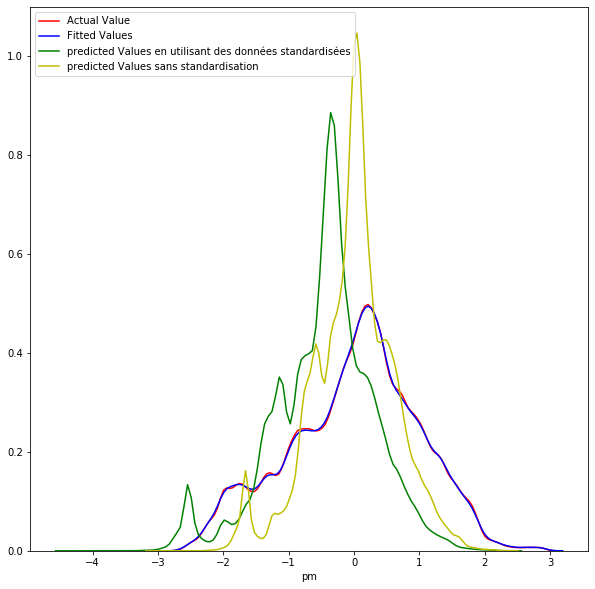

In [39]:
#Visualizing for Multiple Linear Regression y values model1

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(yPredictedTestOls1Inversed, hist=False, color="g", label="predicted Values en utilisant des données standardisées" , ax=ax1);
sns.distplot(yPredictedTestOls2, hist=False, color="y", label="predicted Values sans standardisation" , ax=ax1);



[&lt;matplotlib.lines.Line2D at 0x7f83c0f86a50&gt;]

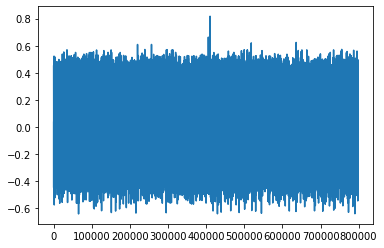

In [40]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols.resid)



[&lt;matplotlib.lines.Line2D at 0x7f83c1116b90&gt;]

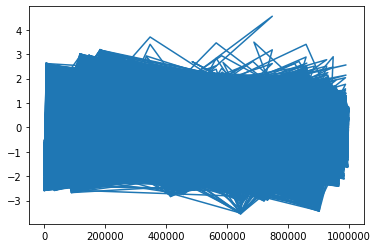

In [41]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols2.resid)

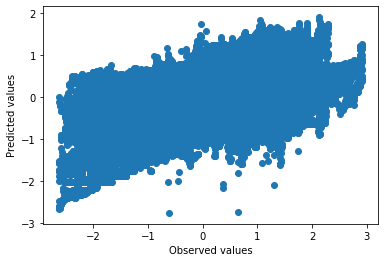

In [42]:
# plot yPredictedTestOls1Inversed
plotPredictedVsObserved(y_test,yPredictedTestOls1Inversed)

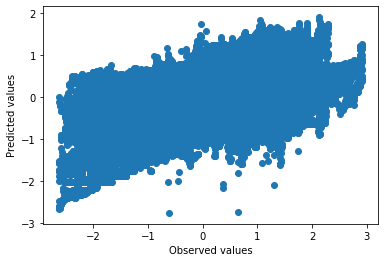

In [43]:

# plot yPredictedTestOls1Inversed
plotPredictedVsObserved(y_test,yPredictedTestOls2)

Text(0, 0.5, &#39;predicted vs actual pm&#39;)

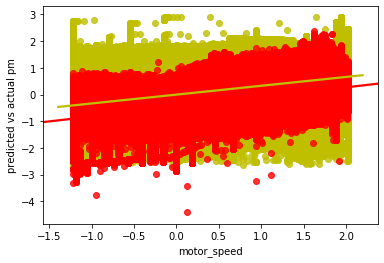

In [44]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=pd.DataFrame(yPredictedTestOls1Inversed, columns=['pm'])["pm"], label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')



Text(0, 0.5, &#39;predicted vs actual pm&#39;)

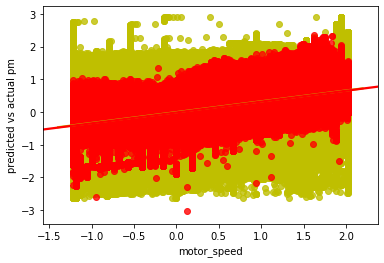

In [45]:
# model withoud scaling
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=yPredictedTestOls2, label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')

Text(0, 0.5, &#39;pm&#39;)

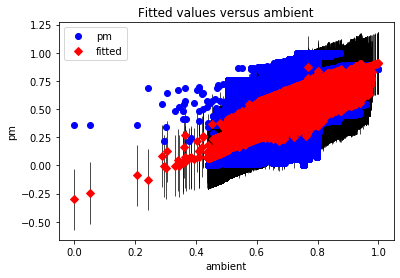

In [46]:
 fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(ols, 0, ax=ax)
ax.set_ylabel("pm")

# KNN

In [47]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfKNN = df.copy()

X=dfKNN.drop(['profile_id', "pm" ,"torque", "stator_tooth",'stator_yoke', 'stator_winding' 
                ,'i_d' 
                ,'coolant' 
                ,'motor_speed'
                    ]
                    , axis=1)
y=dfKNN["pm"]




X['logCoolant'] = logCoolant
X['logI_d'] = logI_d
X['logmotor_speed'] = logmotor_speed


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [48]:
rmse_val = [] #to store rmse values for different k 
crossRmse_val = [] 
from sklearn.metrics import make_scorer
def inverseAndmse (pred, y_truth):
    predinversed = ss.inverse_transform(pred)  
    error = mean_squared_error(y_truth,predinversed) #calculate rmse 
    return error
scoring = make_scorer(inverseAndmse , greater_is_better=False)

for K in range(10):  
    K = K+1  
    model = neighbors.KNeighborsRegressor(n_neighbors = K)  
  
    model.fit(X_train_transformed, y_train_transformed)  #fit the model  
    pred=model.predict(X_test_transformed) #make prediction on test set  
    error =  inverseAndmse(pred, y_test) #calculate rmse 
    cross_val_error = -1 * cross_val_score(model,X_test_transformed,y_test_transformed,cv=8,
                                       scoring=scoring).mean() 
    rmse_val.append(error) #store rmse values  
    crossRmse_val.append(cross_val_error)
    print('RMSE value for k= ' , K , 'is:', error , 'with cv is:', cross_val_error) 




RMSE value for k=  1 is: 0.08882593008909608 with cv is: 0.1516977417114846
RMSE value for k=  2 is: 0.07659456502088605 with cv is: 0.13318533543260602
RMSE value for k=  3 is: 0.07584115909609193 with cv is: 0.13181249719875532
RMSE value for k=  4 is: 0.07683082760053113 with cv is: 0.13421876615195105
RMSE value for k=  5 is: 0.07954367655437576 with cv is: 0.1382231194609321
RMSE value for k=  6 is: 0.08207181614404642 with cv is: 0.14181002055603445
RMSE value for k=  7 is: 0.08482228356463109 with cv is: 0.14581136617580479
RMSE value for k=  8 is: 0.08736599137056526 with cv is: 0.14939897837527671
RMSE value for k=  9 is: 0.08995997916049757 with cv is: 0.15296588131372676
RMSE value for k=  10 is: 0.09250715413504347 with cv is: 0.15635764038982575


In [49]:
 rmse_val[1] > rmse_val[2]

True

In [50]:
    #####could be done using GridSearchCV 
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train_transformed,y_train_transformed)
model.best_params_

{&#39;n_neighbors&#39;: 2}

Text(0.5, 0, &#39;k&#39;)

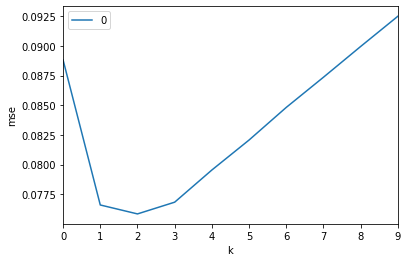

In [51]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve2 = pd.DataFrame(crossRmse_val) #elbow curve 
ax =curve.plot(label='k')
#curve2.plot(ax=ax, label="with cross validation")
ax.set_ylabel("mse")
ax.set_xlabel("k")

In [52]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    cross_val_error = -1 * cross_val_score(model,X_test_transformed,y_test_transformed,cv=8,
                                       scoring='neg_mean_squared_error').mean() 
    rmse_val.append(error) #store rmse values  
    crossRmse_val.append(cross_val_error)
    print('RMSE value for k= ' , K , 'is:', error , 'with cv is:', cross_val_error) 


RMSE value for k=  1 is: 0.07815665065474688 with cv is: 0.1522855678053996
RMSE value for k=  2 is: 0.0683497547685652 with cv is: 0.13389950974570092
RMSE value for k=  3 is: 0.06825581737574128 with cv is: 0.13261337846116364
RMSE value for k=  4 is: 0.07018283620122133 with cv is: 0.13509224040818046
RMSE value for k=  5 is: 0.07344221162402015 with cv is: 0.13916327711665194
RMSE value for k=  6 is: 0.07664177478088102 with cv is: 0.14280269076375368
RMSE value for k=  7 is: 0.07971072958016324 with cv is: 0.14685380304392354
RMSE value for k=  8 is: 0.08271567920765574 with cv is: 0.15048046308326168
RMSE value for k=  9 is: 0.08565947779311965 with cv is: 0.1540858422385634
RMSE value for k=  10 is: 0.08821474096163566 with cv is: 0.15751272336061015


In [53]:
knn_model_rs=KNeighborsRegressor(3).fit(X_train, y_train)
y_pred=knn_model_rs.predict(X_test)
y_pred.shape

(199614,)

In [54]:
knn_model=KNeighborsRegressor(3).fit(X_train_transformed, y_train_transformed)
y2_pred=knn_model.predict(X_test_transformed)
y2_predInversed = ss.inverse_transform(y2_pred)
y2_predInversed.shape

(199614, 1)

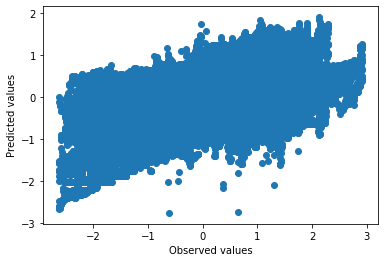

In [55]:

plotPredictedVsObserved(y_test,y2_predInversed)


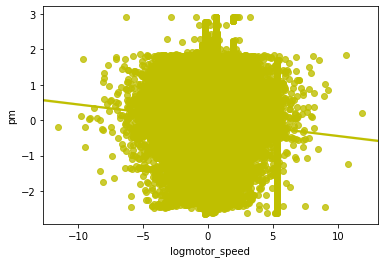

In [56]:
ax1= sns.regplot(x="logmotor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
#sns.regplot(x="logmotor_speed", y=y2_predInversed, label="predicted Value", color="r", data=X_test, ax=ax1);

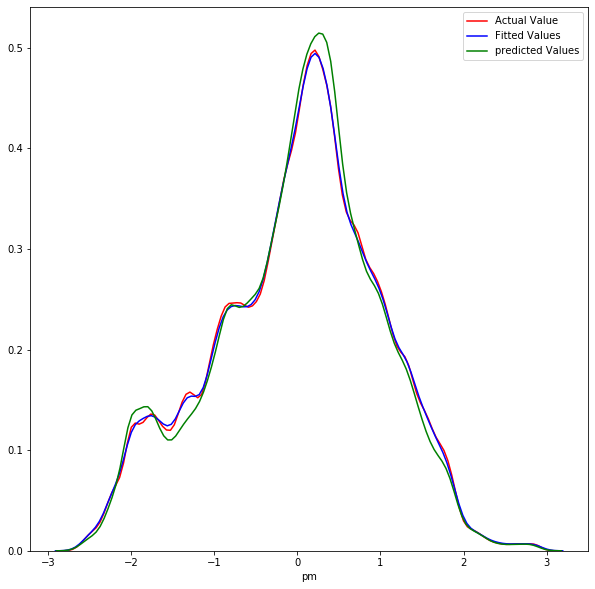

In [57]:

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(y2_predInversed, hist=False, color="g", label="predicted Values" , ax=ax1);